In [ ]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from random import shuffle
import PIL
from PIL import Image
import copy
import cv2
import glob
import cv2
import os 
from os import path
from skimage.color import lab2rgb
torch.set_default_tensor_type('torch.FloatTensor')
import torch.nn as nn
from torch.nn import Linear, ReLU, MSELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ConvTranspose2d
from torch.optim import Adam, SGD
from math import log10, sqrt
import numpy as np
from skimage.metrics import structural_similarity
import argparse
import imutils

In [2]:
#Loading data function
images = []
def load_images_from_folder(folder):
    for filename in os.listdir(folder):
        #print(filename)
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            #print('hi')
            images.append((img,filename))
    return images

filename='./face_images/image00000.jpg'
from skimage import io, color
rgb = io.imread(filename)
lab = color.rgb2lab(rgb)

In [3]:
#LAB images
images = load_images_from_folder("./face_images")
L_images = []
ab_images= []
for img,filename in images:
    imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(imageLAB)
    L=np.array(L,dtype=np.float32)
    L=L[np.newaxis,:,:]
    a=np.array(a,dtype=np.float32)
    b=np.array(b,dtype=np.float32)
    ab=[]
    ab.append(a)
    ab.append(b)
    ab=np.array(ab)
    ab_images.append(torch.tensor(ab))
    L_images.append(torch.tensor(L))

In [4]:
#Train & Test data
train_percentage=90
train_size=int((975/100)*train_percentage)
test_size=975-train_size
all_indices=np.arange(0,975)
np.random.shuffle(all_indices)
train_L=[]
train_ab=[]
test_L=[]
test_ab=[]
for i in all_indices[:train_size]:
    train_L.append(L_images[i])
    train_ab.append(ab_images[i])
for i in all_indices[train_size:]:
    test_L.append(L_images[i])
    test_ab.append(ab_images[i])
train_L=torch.stack(train_L, dim=0)
train_ab=torch.stack(train_ab, dim=0)
test_L=torch.stack(test_L, dim=0)
test_ab=torch.stack(test_ab, dim=0)

# Convolution Neural Network with upsampling and downsampling layers

In [5]:
class Convnet(nn.Module):   
    def __init__(self):
        super(Convnet, self).__init__()

        self.convolution_layers = Sequential(
            Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            nn.ReLU(),
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            nn.ReLU(),
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(),
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            nn.ReLU(),
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.deconvolution_layers = Sequential(
            ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            nn.ReLU(),
            ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(),
            ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            nn.ReLU(),
            ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            nn.ReLU(),
            ConvTranspose2d(8, 2, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(2),
            nn.ReLU()
        )


    # Defining the forward pass    
    def forward(self, x):
        x = self.convolution_layers(x)
        x = self.deconvolution_layers(x)
        return x

# Predicting ab channels given L channel using CNN

Device cpu
Printing train data shape
torch.Size([682, 1, 128, 128])
Printing train ab shape
torch.Size([682, 2, 128, 128])
Printing test data shape
torch.Size([293, 1, 128, 128])
Printing test ab shape
torch.Size([293, 2, 128, 128])
batch_size: 10
num_epochs: 100
learning_rate: 0.01
batches: 68
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10):

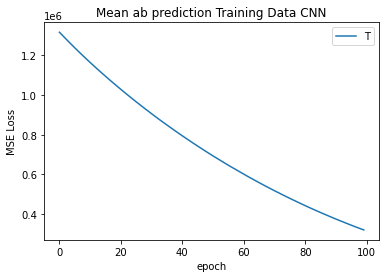

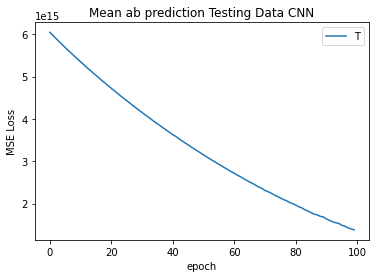

In [33]:


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device="cpu"
print("Device", device)


batch_size = 10
num_epochs = 500
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
#batch_size=1

model = Convnet()
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()

# Additional epochs

Device cpu
Printing train data shape
torch.Size([877, 1, 128, 128])
Printing train ab shape
torch.Size([877, 2, 128, 128])
Printing test data shape
torch.Size([98, 1, 128, 128])
Printing test ab shape
torch.Size([98, 2, 128, 128])
batch_size: 10
num_epochs: 100
learning_rate: 0.01
batches: 87
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): B

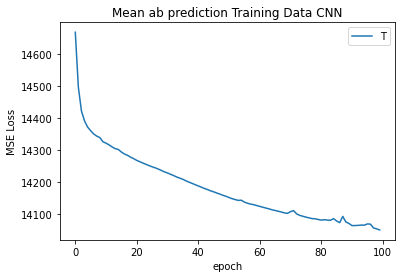

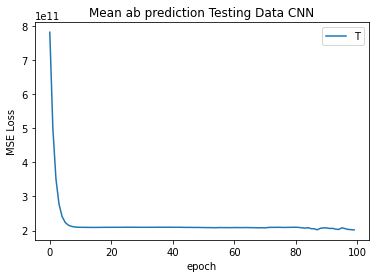

In [17]:
model=torch.load('colorizer.pkl')
device="cpu"
print("Device", device)


batch_size = 10
num_epochs = 100
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()
#torch.save(model, './colorizer.pkl')

In [13]:
torch.save(model, './colorizer.pkl')

# Additional Epochs

Device cpu
Printing train data shape
torch.Size([877, 1, 128, 128])
Printing train ab shape
torch.Size([877, 2, 128, 128])
Printing test data shape
torch.Size([98, 1, 128, 128])
Printing test ab shape
torch.Size([98, 2, 128, 128])
batch_size: 10
num_epochs: 100
learning_rate: 0.01
batches: 87
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): B

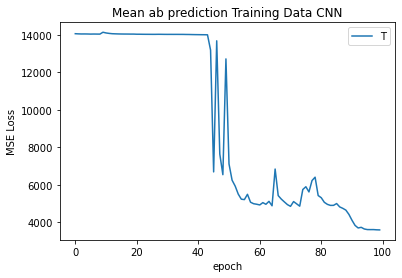

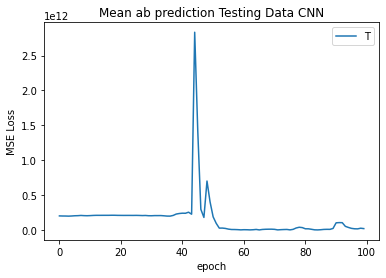

In [18]:
model=torch.load('colorizer.pkl')
device="cpu"
print("Device", device)


batch_size = 10
num_epochs = 100
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()
#torch.save(model, './colorizer.pkl')

# Additional epochs

Device cpu
Printing train data shape
torch.Size([877, 1, 128, 128])
Printing train ab shape
torch.Size([877, 2, 128, 128])
Printing test data shape
torch.Size([98, 1, 128, 128])
Printing test ab shape
torch.Size([98, 2, 128, 128])
batch_size: 10
num_epochs: 100
learning_rate: 0.01
batches: 87
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): B

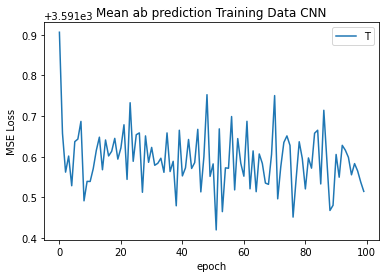

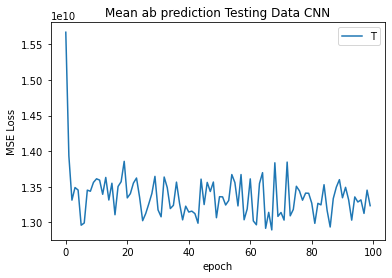

In [19]:
model=torch.load('colorizer.pkl')
device="cpu"
print("Device", device)


batch_size = 10
num_epochs = 100
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()
#torch.save(model, './colorizer.pkl')

# GPU Computing

# Garbage collection in GPU Computing

In [6]:
#Carrying out garbage collection for preventing out of memory error
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#torch command for enabling cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Scaling the input data and then training Convnet with GPU

Device cuda:3
Printing train data shape
torch.Size([877, 1, 128, 128])
Printing train ab shape
torch.Size([877, 2, 128, 128])
Printing test data shape
torch.Size([98, 1, 128, 128])
Printing test ab shape
torch.Size([98, 2, 128, 128])
batch_size: 10
num_epochs: 100
learning_rate: 0.01
batches: 87
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10)

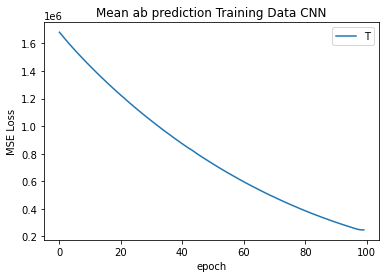

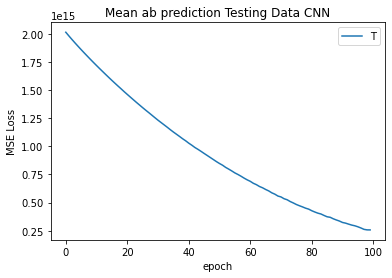

In [42]:
model=Convnet()
device="cuda:3"
print("Device", device)


batch_size = 10
num_epochs = 100
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data=train_data/255
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
test_data=test_data/255
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()
#torch.save(model, './colorizer.pkl')

In [43]:
torch.save(model, './scaled_colorizer.pkl')

# More epochs on GPU 

Device cuda:3
Printing train data shape
torch.Size([877, 1, 128, 128])
Printing train ab shape
torch.Size([877, 2, 128, 128])
Printing test data shape
torch.Size([98, 1, 128, 128])
Printing test ab shape
torch.Size([98, 2, 128, 128])
batch_size: 10
num_epochs: 100
learning_rate: 0.01
batches: 87
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10)

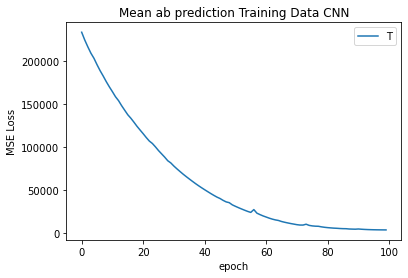

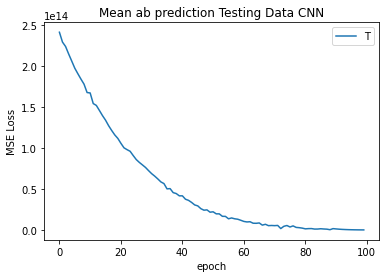

In [45]:
model=torch.load('./scaled_colorizer.pkl')
device="cuda:3"
print("Device", device)


batch_size = 10
num_epochs = 100
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data=train_data/255
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
test_data=test_data/255
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()
#torch.save(model, './colorizer.pkl')

In [46]:
torch.save(model, './scaled_colorizer.pkl')

Device cuda:3
Printing train data shape
torch.Size([877, 1, 128, 128])
Printing train ab shape
torch.Size([877, 2, 128, 128])
Printing test data shape
torch.Size([98, 1, 128, 128])
Printing test ab shape
torch.Size([98, 2, 128, 128])
batch_size: 10
num_epochs: 100
learning_rate: 0.01
batches: 87
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10)

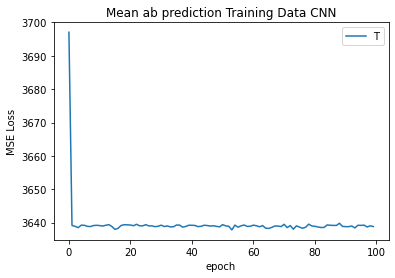

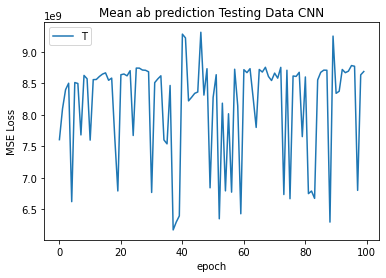

In [14]:
import gc
gc.collect()
torch.cuda.empty_cache()
model=torch.load('./scaled_colorizer.pkl')
device="cuda:3"
print("Device", device)


batch_size = 10
num_epochs = 100
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data=train_data/255
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
test_data=test_data/255
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()
#torch.save(model, './colorizer.pkl')

In [15]:
torch.save(model, './scaled_colorizer.pkl')

# More epochs on GPU

Device cuda:3
Printing train data shape
torch.Size([877, 1, 128, 128])
Printing train ab shape
torch.Size([877, 2, 128, 128])
Printing test data shape
torch.Size([98, 1, 128, 128])
Printing test ab shape
torch.Size([98, 2, 128, 128])
batch_size: 10
num_epochs: 100
learning_rate: 0.01
batches: 87
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10)

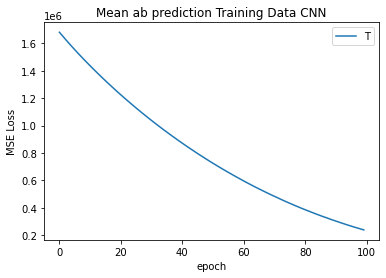

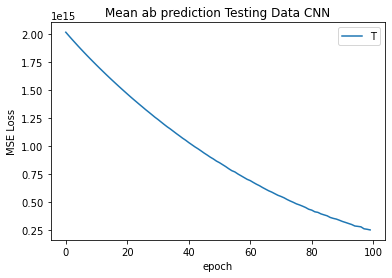

In [7]:
import gc
gc.collect()
torch.cuda.empty_cache()
model=Convnet()
device="cuda:3"
print("Device", device)


batch_size = 10
num_epochs = 100
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data=train_data/255
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
test_data=test_data/255
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()
#torch.save(model, './colorizer.pkl')

# Improving the performance of colorizer

# Scaling the input data and then training CNN with more feature maps

In [48]:
class Convnet2(nn.Module):   
    def __init__(self):
        super(Convnet2, self).__init__()

        self.convolution_layers = Sequential(
            Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            nn.ReLU(),
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(),
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            nn.ReLU(),
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),
            nn.ReLU(),
            Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.deconvolution_layers = Sequential(
            ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),
            nn.ReLU(),
            ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            nn.ReLU(),
            ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(),
            ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            nn.ReLU(),
            ConvTranspose2d(16, 2, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(2),
            nn.ReLU()
        )


    # Defining the forward pass    
    def forward(self, x):
        x = self.convolution_layers(x)
        x = self.deconvolution_layers(x)
        return x

In [ ]:
model=Convnet2()
device="cpu"
print("Device", device)


batch_size = 5
num_epochs = 25
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data=train_data/max(train_data[0])
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
test_data=test_data/max(train_data[0])
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()
#torch.save(model, './colorizer.pkl')

# Saving the results

# Colorizing images from test set and saving the results

In [6]:
model=torch.load('colorizer.pkl')

In [44]:
all_indices=np.arange(0,98)
np.random.shuffle(all_indices)
test_indices=all_indices[:10]
for indice in test_indices:
    if path.exists('./colorized_images_test') == False:
        os.mkdir('./colorized_images_test')
    test_image_L=test_L[indice]
    test_image_L=torch.unsqueeze(test_image_L,dim=0)
    test_image_ab=model(test_image_L)
    f=torch.stack((test_image_L[0][0],test_image_ab[0][0],test_image_ab[0][1]),dim=0).clone().detach()
    p=np.array(f)
    data = np.moveaxis(p, 0, 2)
    img = data.astype(np.uint8)
    img=cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    plt.imsave('./colorized_images_test/test{}.jpg'.format(indice),img)

#  Colorizing images from train set and saving the results

In [45]:
model=torch.load('colorizer.pkl')

In [46]:
all_indices=np.arange(0,800)
np.random.shuffle(all_indices)
test_indices=all_indices[:10]
for indice in test_indices:
    if path.exists('./colorized_images_train') == False:
        os.mkdir('./colorized_images_train')
    train_image_L=train_L[indice]
    train_image_L=torch.unsqueeze(train_image_L,dim=0)
    train_image_ab=model(train_image_L)
    f=torch.stack((train_image_L[0][0],train_image_ab[0][0],train_image_ab[0][1]),dim=0).clone().detach()
    p=np.array(f)
    data = np.moveaxis(p, 0, 2)
    img = data.astype(np.uint8)
    img=cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    #img=cv2.cvtColor(data,cv2.COLOR_LAB2RGB)
    plt.imsave('./colorized_images_train/train{}.jpg'.format(indice),img)

# Colorizing images from test set and saving the results (Using scaled model)

In [47]:
device="cpu"
model=torch.load('scaled_colorizer.pkl')
model.to(device)

Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (deconvolution_layers): Sequential(
    (0): C

In [49]:
all_indices=np.arange(0,98)
np.random.shuffle(all_indices)
test_indices=all_indices[:10]
test_indices=torch.tensor(test_indices)
test_indices=test_indices.to(device)
for indice in test_indices:
    if path.exists('./scaled_colorized_images') == False:
        os.mkdir('./scaled_colorized_images')
    test_image_L=test_L[indice]
    test_image_L=test_image_L.to(device)
    test_image_L=torch.unsqueeze(test_image_L,dim=0)
    test_image_ab=model(test_image_L)
    f=torch.stack((test_image_L[0][0],test_image_ab[0][0],test_image_ab[0][1]),dim=0).clone().detach()
    p=np.array(f.cpu())
    data = np.moveaxis(p, 0, 2)
    img = data.astype(np.uint8)
    img=cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    plt.imsave('./scaled_colorized_images/{}.jpg'.format(indice),img)

# Colorizing images randomly from face images dataset

In [37]:
#LAB images
images = load_images_from_folder("./face_images")
L_images = []
ab_images= []
all_indices=np.arange(20)
np.random.shuffle(all_indices)
indices=all_indices[:10]
names=[]
counter=0
for img,filename in images:
    if filename[0]=='i' and counter<10:
        #print(int(filename[-6:-4]))
        names.append(int(filename[-6:-4]))
        cv2.imwrite('./colorized_random_images/original_image_{}.jpg'.format(int(filename[-6:-4])), img)
        imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        L, a, b = cv2.split(imageLAB)
        cv2.imwrite('./colorized_random_images/input_image_{}.jpg'.format(int(filename[-6:-4])), L)
        L=np.array(L,dtype=np.float32)
        L=L[np.newaxis,:,:]
        a=np.array(a,dtype=np.float32)
        b=np.array(b,dtype=np.float32)
        ab=[]
        ab.append(a)
        ab.append(b)
        ab=np.array(ab)
        ab_images.append(torch.tensor(ab))
        L_images.append(torch.tensor(L))
        counter+=1

In [38]:
for i in range(10):
    train_image=L_images[i]
    #print(train_image)
    train_image=torch.unsqueeze(train_image,dim=0)
    train_image_ab=model(train_image)
    f=torch.stack((train_image[0][0],train_image[0][0],train_image_ab[0][1]),dim=0).clone().detach()
    p=np.array(f)
    data = np.moveaxis(p, 0, 2)
    img = data.astype(np.uint8)
    img=cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    #img=cv2.cvtColor(data,cv2.COLOR_LAB2RGB)
    plt.imsave('./colorized_random_images/output{}.jpg'.format(names[i]),img)

# Evaluation metrics

In [62]:
def PSNR(original, colorized):
    mse = np.mean((original - colorized) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def calc_PSNR(image1,image2):
    original = cv2.imread(image1)
    colorized = cv2.imread(image2)
    value = PSNR(original, colorized)
    return value

def calc_SSIM(image1,image2):
    image1=cv2.imread(image1)
    image2=cv2.imread(image2)
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    (score, diff) = structural_similarity(gray1, gray2, full=True)
    return score

In [50]:
total_psnr=0
count=0
total_ssim=0
#image number is stored in all_indices list
all_indices=[3,11,12,14,26,46,50,82,85,93]
for indice in all_indices:
    count+=1
    image1='./colorized_random_images/original_image_{}.jpg'.format(indice)
    image2='./colorized_random_images/output{}.jpg'.format(indice)
    total_psnr+=calc_PSNR(image1,image2)
    total_ssim+=calc_SSIM(image1,image2)
average_psnr=total_psnr/count
average_ssim=total_ssim/count
print(f"Average PSNR value is {average_psnr} dB")
print(f"Average SSIM value is {average_ssim}")

Average PSNR value is 28.462568831949948 dB
Average SSIM value is 0.9243574367606995
